# MFCC

## Discrete Fourier Transform¶

반복되는 이산시간 시계열 -> 특정 주파수/위상을 가진 사인파의 합으로 변환

## FFT(Fast Fourier Transform)

2^N 개의 이산시간 시계열에 대해 적은 계산량으로 DFT 계산

In [1]:
import numpy as np
import matplotlib.pyplot as plt

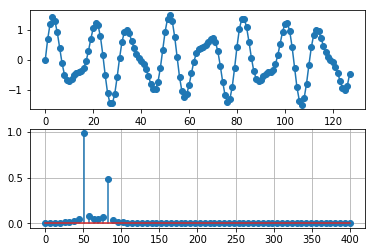

In [2]:
from scipy.fftpack import fft

N = 128
T = 1.0/800.0

x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) +0.5*np.sin(80.0 * 2.0*np.pi*x)

yf = fft(y, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.subplot(211)
plt.plot(y, 'o-')

plt.subplot(212)
plt.stem(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()

plt.show()

## Spectrum

PSD(power spectral density)

In [3]:
import librosa
import librosa.display
import IPython.display
import scipy.io.wavfile

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
import soundfile as sf

data, samplerate = sf.read('104_003_0019.flac')
sf.write('104_003_0019.wav', data, samplerate)

In [5]:
sample_rate, audio = scipy.io.wavfile.read('104_003_0019.wav')

In [6]:
IPython.display.Audio('104_003_0019.wav')

In [7]:
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 16000Hz
Audio duration: 10.9286875s


In [8]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

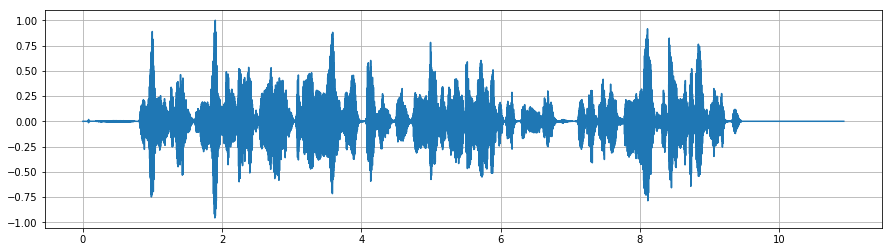

In [9]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

## Audio Framing
Because audio is a non stationary process, the FFT will produce distortions. To overcome this we can assume that the audio is a stationary process for a short periods of time. Because of that we devide the signal into short frames. Each audio frame will be the same size as the FFT. Also we want the frames to overlap. We do that so that the frames will have some correlation between them and because we loose the information on the edges of each frame after applying a window function.

In [10]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    # Pads an array.
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [11]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (729, 2048)


Now we have framed audio matrix with the size of frame number X FFT size.

In [12]:
print("First frame:")
audio_framed[1]

First frame:


array([-6.13779346e-05, -6.13779346e-05,  0.00000000e+00, ...,
       -1.71858217e-03, -1.07411386e-03, -1.28893663e-03])

In [13]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([ 3.06889673e-05, -3.06889673e-05, -9.20669019e-05, ...,
       -6.13779346e-05,  2.14822771e-04, -2.14822771e-04])

## Convert to frequency domain
Now we will convert the audio, which is currently in the time domain, to frequency domain. The FFT assumes the audio to be periodic and continues. By framing the signal we assured the audio to be periodic. To make the audio continues, we apply a window function on every frame. If we wont do that, We will get high frequency distortions. To overcome this, we first need to apply a window function to the framed audio and then perforn FFT. The window assures that both ends of the signal will end close to zero.

Choosing the correct window is hard and takes time. For simplicity we will choose the Hanning window. [7]

In [14]:
from scipy.signal import get_window

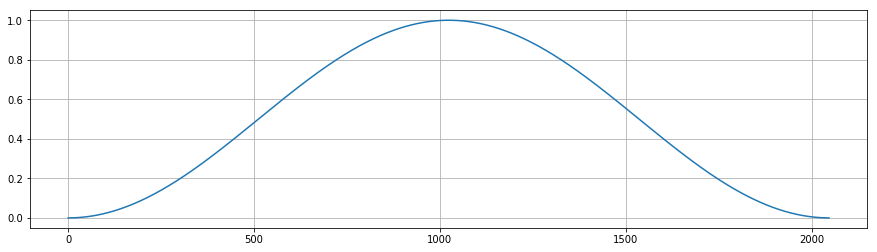

In [15]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

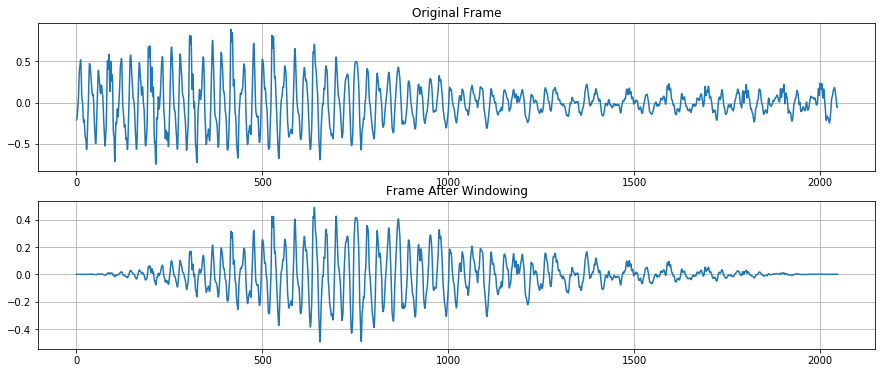

In [16]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In the plot above you can see the that both ends of the frame end on different places on the y axis. You can see that the window brought the edges of each frame closer to zero.

Now lets perform the FFT. After we do the FFT we only take the the positive part of the spectrum (first half +1).

In [17]:
import scipy.fftpack as fft

In [19]:
audio_win.shape

(729, 2048)

In [20]:
audio_winT.shape

(2048, 729)

In [21]:
audio_fft.shape

(729, 1025)

In [18]:
audio_winT = np.transpose(audio_win)
# Permute the dimensions of an array.

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
# Return a new array of given shape and type, without initializing entries.
# Whether to store multi-dimensional data in row-major (C-style) or column-major (Fortran-style) order in memory.

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

## Calculate signal power

In [22]:
audio_power = np.square(np.abs(audio_fft))
# Return the element-wise square of the input.

print(audio_power.shape)

(729, 1025)


## MEL-spaced filterbank
Here we compute the MEL-spaced filterbank and then pass the framed audio through them. That will give us information about the power in each frequency band. The filters can be constructed for any frequency band but for our example we will look on the entire sampled band.

What spessial with the MEL-spaced filterbank is the spacing between the filters which grows exponentially with frequency. The filterbank can be made for any frequency band. Here we will compute the filterbank for the entire frequency band.

In [24]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 8000.0


## Compute filter points
First we construct filter points that determines the start and stop of the filters. To do that we first convert the two filterbank edges to the MEL space. After that we construct a lineary spaced array between the two MEL frequencies. Then we convert the array to the frequency space and finally we normalize the array to the FFT size and choose the associated FFT values.

This process is shown in the picture below:
![](https://preview.ibb.co/hrFnrx/MEL.png)

In [25]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [26]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [27]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 2840.023046708319


array([  0,   8,  18,  32,  48,  69,  96, 129, 170, 223, 288, 371])

## Construct the filterbank

In [28]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

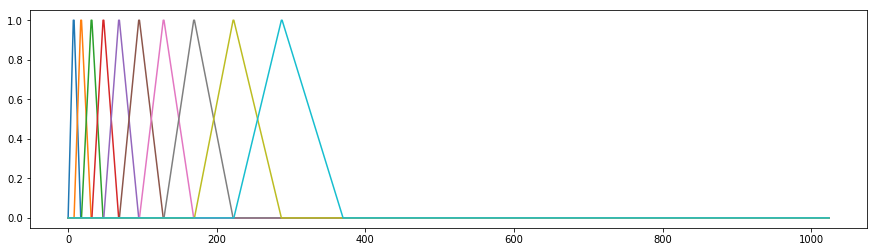

In [29]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

Next we divide the triangular MEL weights by the width of the MEL band (area normalization). If we wont normalize the filters, we will see the noise increase with frequency because of the filter width.

In [30]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

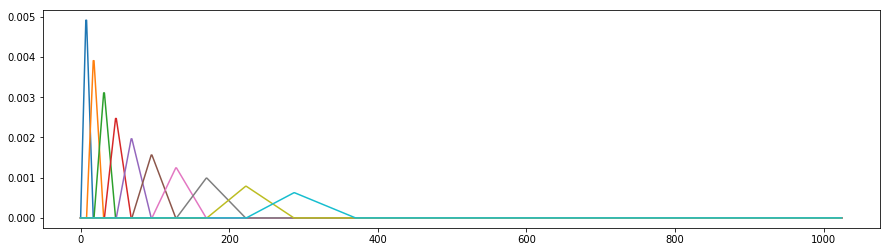

In [31]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

## Filter the signal 

In [32]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 729)

Now we have a matrix represemting the audio power in all 10 filters in different time frames

## Generate the Cepstral Coefficents
The final step in generating the MFCC is to use the Discrete Cosine Transform (DCT). We will use the DCT-III. This type of DCT will extract high frequency and low frequency changes in the the signal [8] [9].

In [33]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [34]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 729)

In [35]:
cepstral_coefficents[:, 0]

array([-1.89365864e+02,  2.28051052e+01, -1.98698539e+00, -1.09511953e+00,
       -6.96878774e+00, -6.09413829e+00, -5.74886345e+00, -5.25539323e+00,
       -2.74199439e-01, -4.19568691e-01,  2.82514201e-13,  4.19568691e-01,
        2.74199439e-01,  5.25539323e+00,  5.74886345e+00,  6.09413829e+00,
        6.96878774e+00,  1.09511953e+00,  1.98698539e+00, -2.28051052e+01,
        2.67803773e+02, -2.28051052e+01,  1.98698539e+00,  1.09511953e+00,
        6.96878774e+00,  6.09413829e+00,  5.74886345e+00,  5.25539323e+00,
        2.74199439e-01,  4.19568691e-01, -8.53494128e-14, -4.19568691e-01,
       -2.74199439e-01, -5.25539323e+00, -5.74886345e+00, -6.09413829e+00,
       -6.96878774e+00, -1.09511953e+00, -1.98698539e+00,  2.28051052e+01])

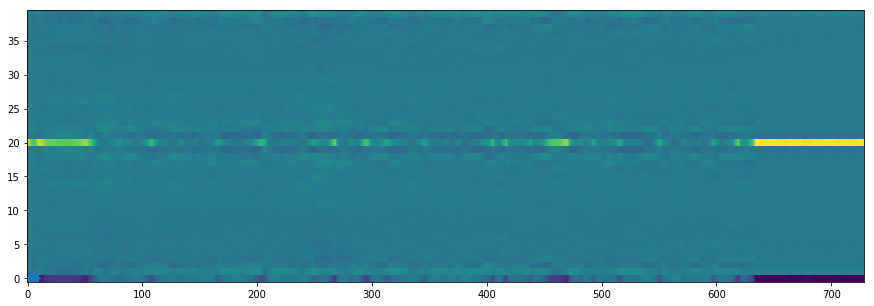

In [36]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

## Conclution
The MFCC is a good algorithm to extract high frequency and low frequency information. There are many parts that can be changed depending on the application. One thing that we might want to check is how the power is scattered across frequency band and choosing the filter amount based on that.

# MFCC package 이용

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from librosa.feature import mfcc

In [70]:
sr, y = wavfile.read('104_003_0019.wav')

In [76]:
y = np.cast[float](y)

In [78]:
y.dtype

dtype('float64')

In [67]:
np.cast[float](sr)

array([ 3.,  6.,  8., ..., -4.,  6., -4.])

In [ ]:
sr

In [83]:
mfcc_features = mfcc(y=y, sr=sr, n_mfcc=40)

In [89]:
from python_speech_features import mfcc

In [88]:
from python_speech_features import logfbank

In [93]:
mfcc_features1 = mfcc(signal=y, samplerate=sr)

In [95]:
mfcc_features.shape,mfcc_features.shape

((40, 342), (40, 342))

In [96]:
mfcc_features == mfcc_features1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [97]:
filterbank_features = logfbank(y, sr)

In [98]:
filterbank_features.shape

(1092, 26)

In [100]:
print('\nMFCC:\nNumber of windows =', mfcc_features.shape[0])
print('Length of each feature =', mfcc_features.shape[1])
print('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print('Length of each feature =', filterbank_features.shape[1])


MFCC:
Number of windows = 40
Length of each feature = 342

Filter bank:
Number of windows = 1092
Length of each feature = 26


Text(0.5,1.05,'MFCC')

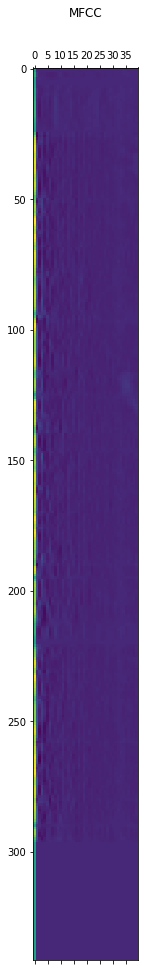

In [101]:
mfcc_features = mfcc_features.T
plt.matshow(mfcc_features)
plt.title('MFCC')

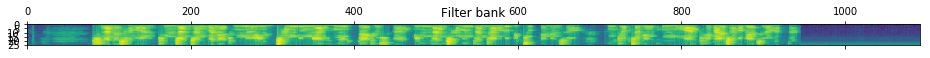

In [102]:
filterbank_features = filterbank_features.T
plt.matshow(filterbank_features)
plt.title('Filter bank')
plt.show()